## Checkpoint 12 - Week 8

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn import model_selection, preprocessing
from sklearn.metrics import confusion_matrix, roc_curve

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

import dt_utils as dt
import nn_utils as nn

In [2]:
DIR = os.path.join(os.getcwd(), 'download')
M_H = 1 # TeV/c^2

#### Exercise #1 (1 point):
Open the three background and one signal CSV files, and feed the data into four pandas.core.frame.DataFrame objects. One of them is significantly larger than others, and it will take much longer to unpack. You may want to use command os.path.getsize as a warning to your reader/self. Carry out the usual sanity checks (```pandas.core.frame.DataFrame.head(5)```), and determine if data-cleaning is necessary (```pandas.core.frame.DataFrame.dropna(inplace = True)```). 

Plot 1D distributions for the first 9 variables listed in Table 1, with one plot per variable and the distributions categorised by physics process (1 category for signal, 3 categories for background). Make sure the distributions are normalised (i.e. we are interested in shape differences here, not the overall integrated contributions), and that they are clearly distinct for the different processes (e.g. use different colours and non-filled histograms). You can use a loop over the input features to simplify the code, and you can ignore the units on the x-axis.


In [3]:
files = os.listdir(DIR)

for file in files:
    print(os.path.getsize(os.path.join(DIR, file))/(1024*1024)) # in MB

32.12821674346924
10.379656791687012
18.650080680847168
1336.9464206695557


In [4]:
bkg1 = pd.read_csv(os.path.join(DIR, 'ggH1000.csv'))
bkg2 = pd.read_csv(os.path.join(DIR, 'Top.csv'))
bkg3 = pd.read_csv(os.path.join(DIR, 'Zjets.csv'))
sig = pd.read_csv(os.path.join(DIR, 'Diboson.csv'))

In [5]:
print(bkg1.shape)
bkg1 = bkg1.dropna()
print(bkg1.shape)
bkg1.head()

(50013, 25)
(50013, 25)


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,0.013603,44495.770,1,87475.55,627990.80,0.116438,0.889354,675246.25,-0.851387,...,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,1,0.242178,34441.156,1,90507.31,409780.94,0.191874,1.485706,604275.70,1.041311,...,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,2,0.096412,21625.379,0,89765.85,344668.30,0.122089,1.219367,612517.94,0.417858,...,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,3,0.096373,21855.973,1,92313.63,535629.06,0.061306,0.592705,482630.90,0.438590,...,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,4,0.073052,33677.380,1,89451.92,296257.47,0.159334,0.724910,459737.80,1.213717,...,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90


In [6]:
print(bkg2.shape)
bkg2 = bkg2.dropna()
print(bkg2.shape)
bkg2.head()

(92416, 25)
(92416, 25)


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,2.004522e-09,51609.760,1,35253.492,35612.324,0.109581,1.435712,461309.30,-1.195378,...,0.164823,1.042927,38513.980,11072.072,1,-0.665443,-0.969063,9003.888,245723.92,-1.0
1,1,1.822626e-09,225038.800,1,20311.205,38644.793,0.090346,2.403266,276659.70,0.387434,...,-1.871251,0.601309,34191.734,34626.312,1,-1.975266,1.798074,9425.637,351938.88,-1.0
2,2,1.552981e-09,27090.697,1,134715.500,244261.840,0.212569,1.336584,900965.50,-1.822714,...,0.701193,2.446600,254871.310,17551.730,-1,-0.196344,0.185058,17218.764,1046120.90,-1.0
3,3,1.660535e-09,57572.890,0,69086.836,90045.625,0.133918,1.780693,596016.20,-1.725750,...,-2.305750,0.627527,84608.050,10652.912,1,-0.413642,1.657720,9801.820,301995.70,-1.0
4,4,1.461494e-09,123177.900,0,51731.508,52780.684,0.101556,3.398984,590811.44,1.477704,...,-0.685020,-2.360906,50720.953,15453.791,-1,0.880629,2.436030,10932.975,376986.28,-1.0


In [7]:
print(bkg3.shape)
bkg3 = bkg3.dropna()
print(bkg3.shape)
bkg3.head()

(6579416, 25)
(6579416, 25)


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,-0.790471,177227.420,1,95697.766,64252.690,0.097862,1.895164,425871.88,-1.329446,...,1.782276,-1.057460,76128.370,12476.566,1,-0.289019,1.966965,11973.011,596020.44,-1.0
1,1,0.789204,10660.757,1,90289.914,32506.705,0.000000,0.000000,247948.36,-0.429050,...,-0.918399,-1.229385,40799.945,38147.754,1,0.847265,0.995251,27624.867,260357.19,-1.0
2,2,-0.872639,655334.400,1,92994.430,55287.625,0.059006,2.463149,630492.94,-0.543789,...,-1.091297,0.865696,57988.660,29768.775,1,0.440004,-1.042492,27102.590,422698.44,-1.0
3,3,-0.772697,41489.973,1,89607.580,63405.484,0.265080,2.081222,610611.56,1.776149,...,1.238367,2.127853,55424.742,69817.470,1,0.809497,-2.276664,51873.030,302718.06,-1.0
4,4,1.581337,41731.630,1,90199.480,47187.332,0.093765,2.321676,781746.90,-1.524169,...,-0.116431,1.745413,68312.220,33509.810,1,0.598434,-1.972788,28290.979,461896.25,-1.0


In [8]:
print(sig.shape)
sig = sig.dropna()
print(sig.shape)
sig.head()

(155127, 25)
(155127, 25)


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,0.387345,41920.540,0,187549.810,374316.600,0.127114,1.786927,353161.47,-0.001591,...,1.677279,-1.346853,369495.34,12147.315,1,-0.686657,-2.412152,9755.2705,1014320.10,-1.0
1,1,0.172328,225618.530,0,13106.807,51429.535,0.269517,2.296220,357617.66,-1.066937,...,-2.057147,2.975854,36972.74,34980.440,-1,-1.521354,2.819377,14584.7360,240295.97,-1.0
2,2,0.371392,42284.125,0,84519.230,153790.270,0.051175,3.360730,345472.30,0.704825,...,-0.285897,-0.084159,146895.95,24618.990,-1,0.741342,1.177780,19119.7030,471285.40,-1.0
3,3,0.309902,42735.938,1,76138.640,102611.836,0.117028,0.702838,476446.80,0.095546,...,-0.160614,-2.544057,109699.72,22303.861,1,-1.648011,1.120479,8277.4480,495503.10,-1.0
4,4,0.202772,70475.780,0,86138.000,141886.280,0.053951,3.634348,799487.75,-1.828396,...,-0.499056,0.429884,151453.40,14053.401,-1,-0.171763,2.796952,13848.2230,498823.40,-1.0


In [9]:
background = pd.concat([bkg1, bkg2, bkg3], ignore_index=True)

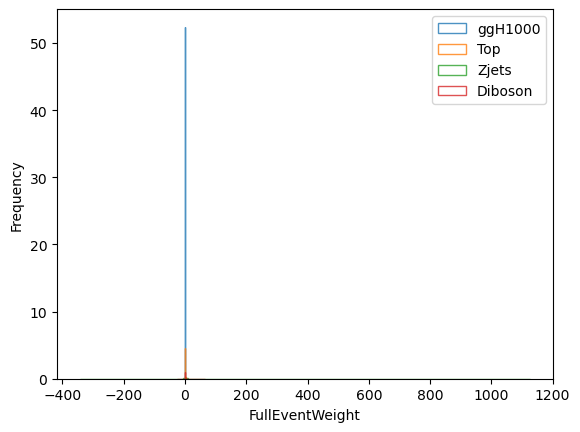

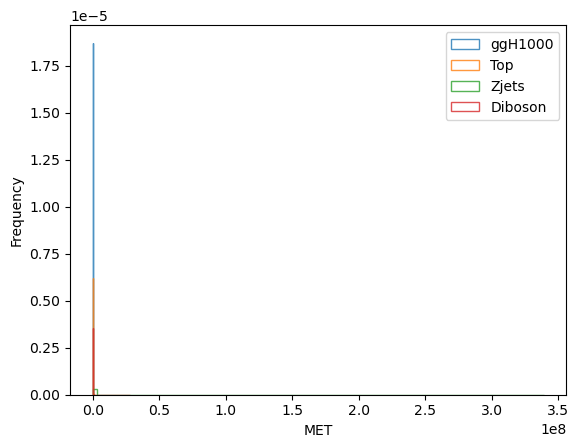

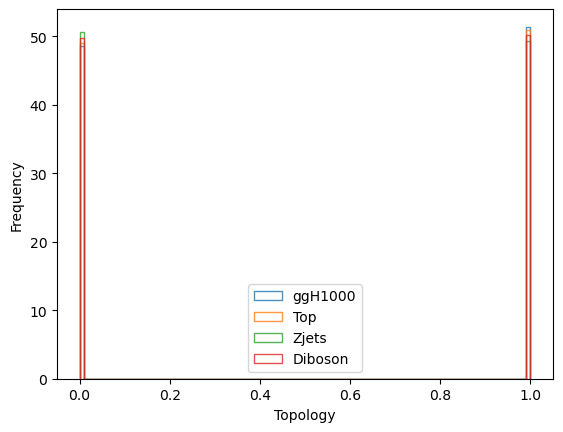

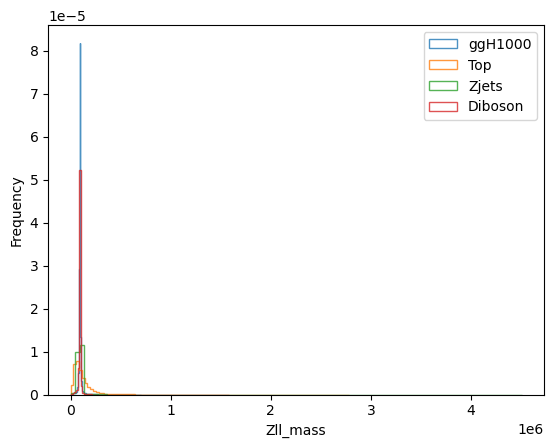

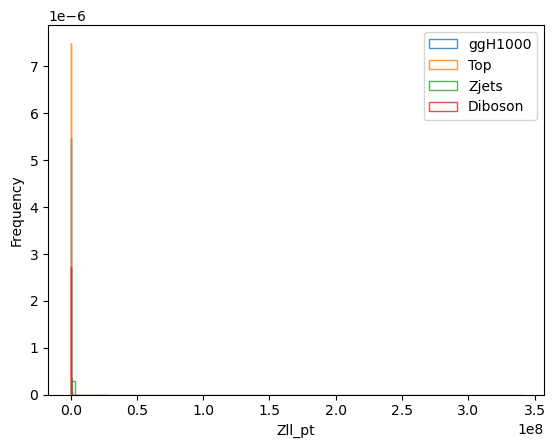

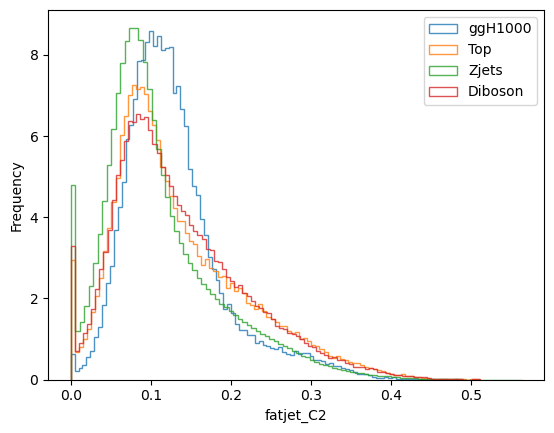

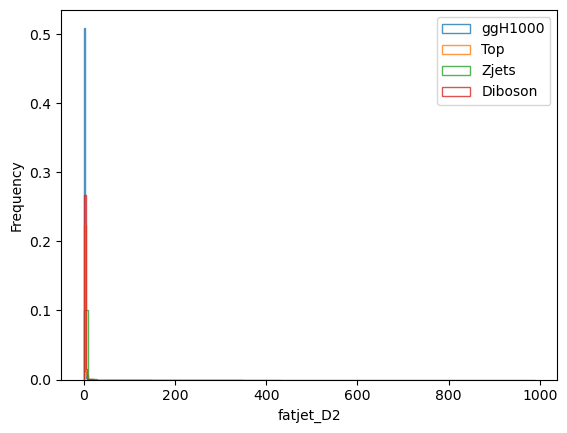

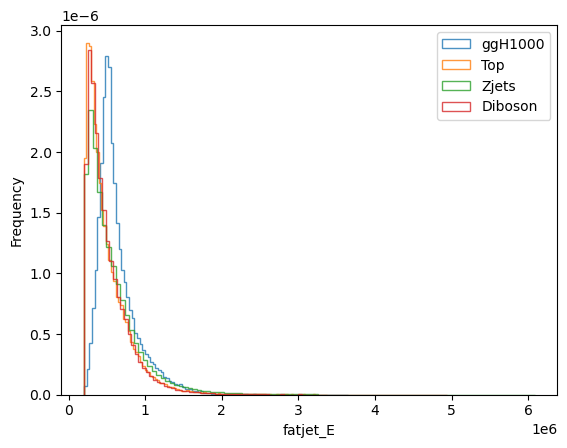

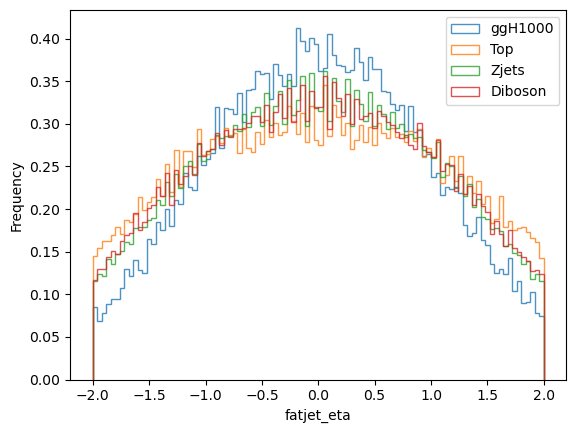

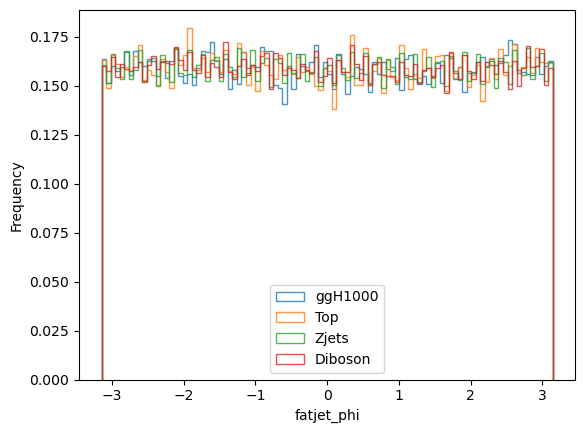

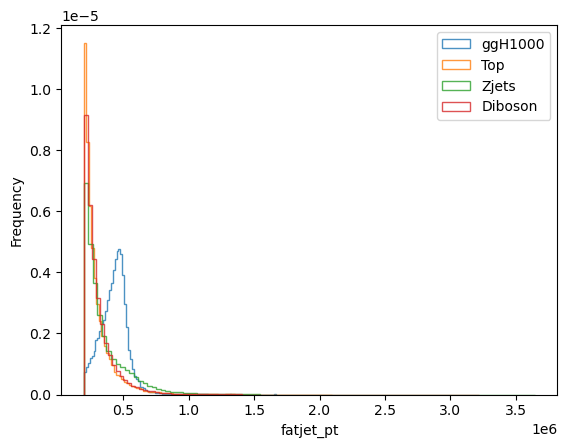

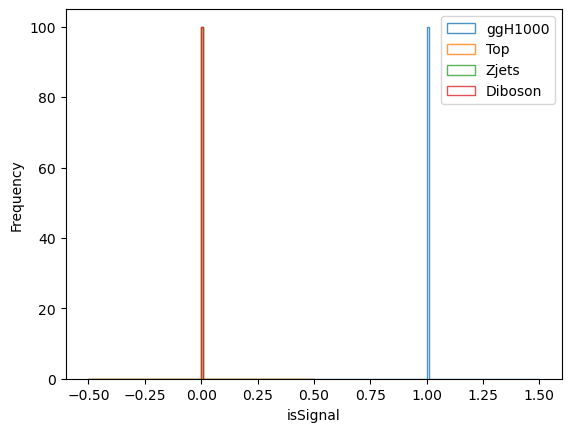

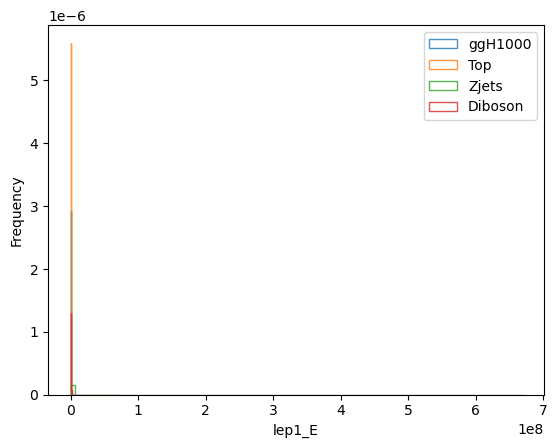

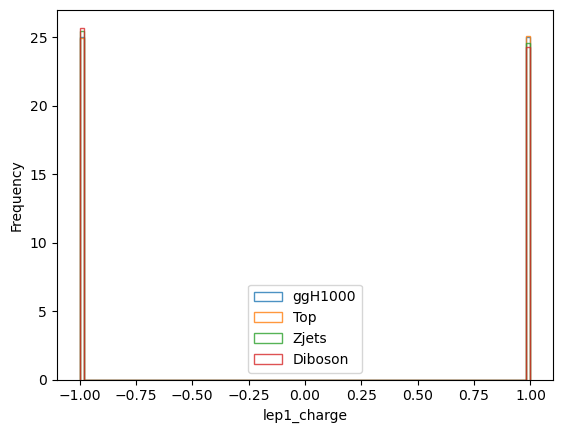

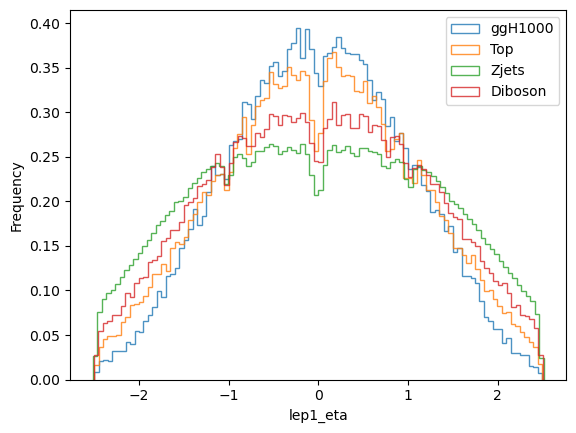

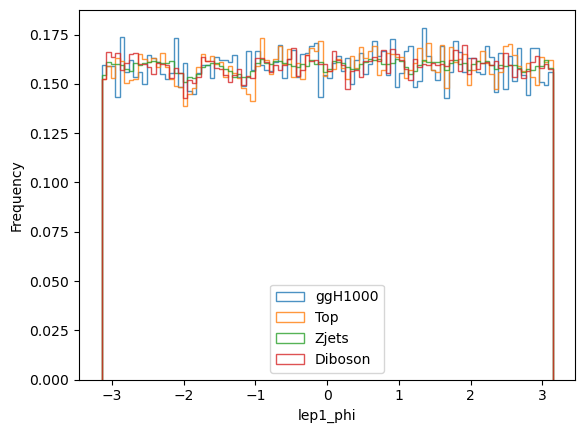

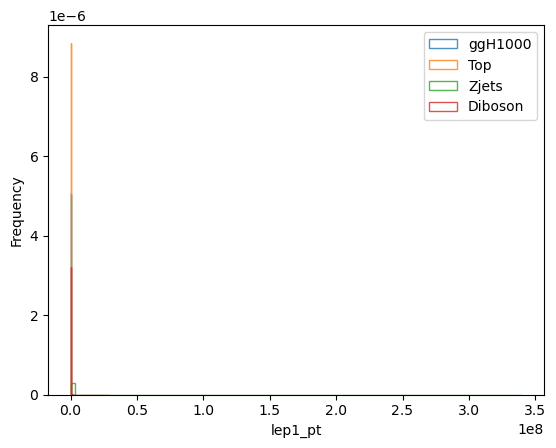

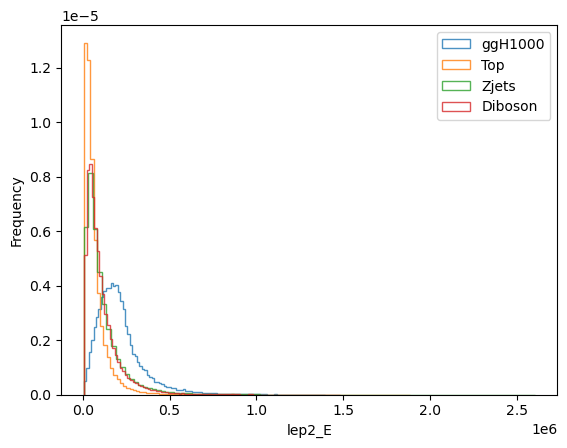

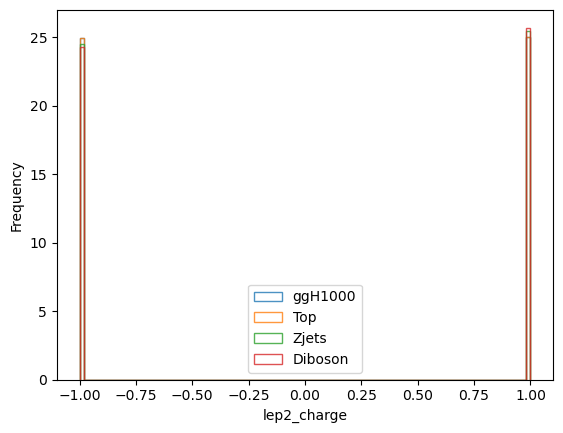

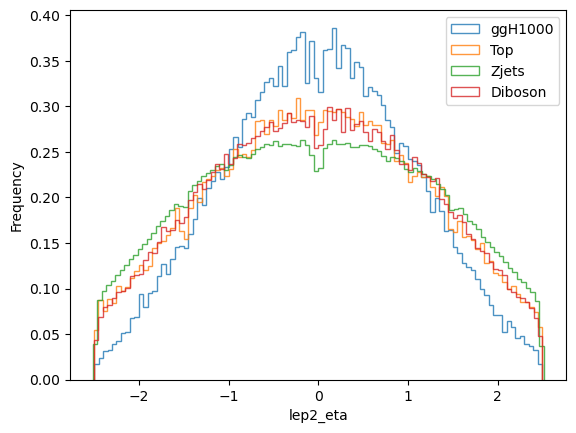

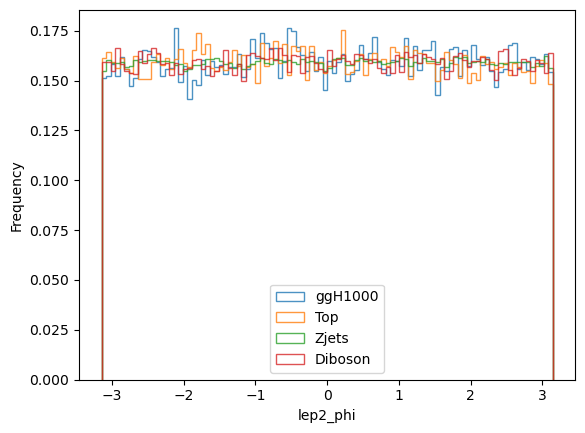

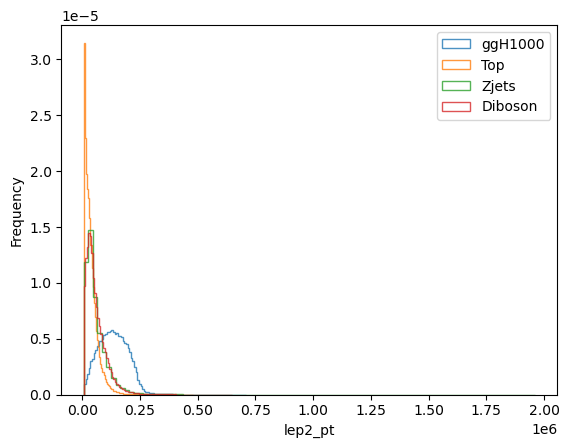

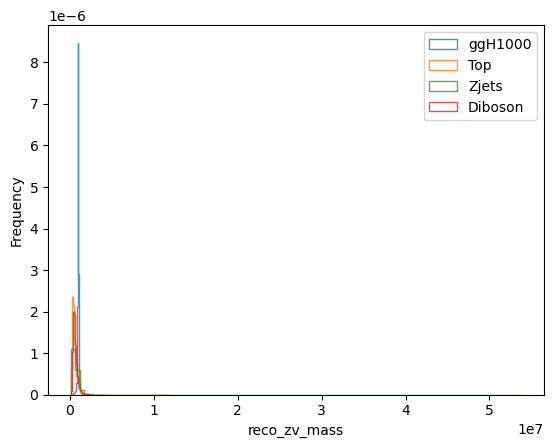

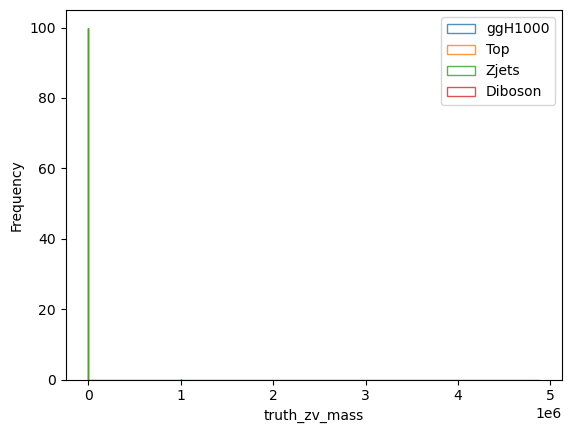

In [10]:
for col in background.columns[1:]:
    plt.figure(dpi=100)

    plt.hist(bkg1[col], bins=100, alpha=0.8, label='ggH1000', density=True, histtype='step')
    plt.hist(bkg2[col], bins=100, alpha=0.8, label='Top', density=True, histtype='step')
    plt.hist(bkg3[col], bins=100, alpha=0.8, label='Zjets', density=True, histtype='step')
    plt.hist(sig[col], bins=100, alpha=0.8, label='Diboson', density=True, histtype='step')

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

#### Exercise #2 (2 points):
(a) (1 point) Put together all background samples to produce one “mega” DataFrame with method pandas.core.frame.DataFrame.concat. You probably also want to be
using the ignore index=True option. 

We want to shuffle the contents of the new DataFrame, as it currently contains ordered events from different background processes, which is unnatural. Use methods ```sklearn.utils.shuffle``` and ```DataFrame.reset index(drop=True)```. Make sure to run this with a fixed random seed, as per good practice for reproducibility of your results. 

Create a training dataset that contains equal numbers of signal and background events. Remember that in the original dataframes the number of background events is much larger than the number of signal events. Create a 50-50 admixture sample with twice the number of signal events (N_{tot} = N_{sig} + N_{bgd} = 2N_{sig}). Use the previously discussed ```concat``` and ```shuffle``` methods.

(b) (1 point) Create a new dataframe containing only the 8 input and 1 output features of interest. Make 2D scatter plots for each combination pair of the 8 input features. Choose a different colour for signal and background (do this by creating a ```wtype = [’Background’, ’Signal’]``` object with the labels of the possible ```N_classes = 2``` categories. You can either write your own code, or recycle function ```dt_utils.featureplot``` that we used in a previous NN checkpoint.


(a)

In [11]:
print(background.shape)
background['isSignal'] = 0
background = background.dropna()
print(background.shape)
background.head()

(6721845, 25)
(6721845, 25)


,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,0.013603,44495.770,1,87475.55,627990.80,0.116438,0.889354,675246.25,-0.851387,...,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,1,0.242178,34441.156,1,90507.31,409780.94,0.191874,1.485706,604275.70,1.041311,...,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,2,0.096412,21625.379,0,89765.85,344668.30,0.122089,1.219367,612517.94,0.417858,...,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,3,0.096373,21855.973,1,92313.63,535629.06,0.061306,0.592705,482630.90,0.438590,...,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,4,0.073052,33677.380,1,89451.92,296257.47,0.159334,0.724910,459737.80,1.213717,...,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90


In [12]:
sig['isSignal'] = 1

In [13]:
print('Variables of Interest:')
for col in background.columns[1:9]:
    print("  ", col)

Variables of Interest:
   FullEventWeight
   MET
   Topology
   Zll_mass
   Zll_pt
   fatjet_C2
   fatjet_D2
   fatjet_E


In [14]:
# run background.reset_index(drop=True) with fixed random seed
background = shuffle(background, random_state=42).reset_index(drop=True)
sig = shuffle(sig, random_state=42).reset_index(drop=True)

In [15]:
# Create a training dataset that contains equal numbers of signal and background events.
# Remember that in the original dataframes the number of background events is much
# larger than the number of signal events. Create a 50-50 admixture sample with twice the
# number of signal events. Use concat and shuffle methods.

dataset = pd.concat([sig, background[:sig.shape[0]]], ignore_index=True)
dataset = shuffle(dataset, random_state=42).reset_index(drop=True)
dataset

,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,2566484,0.801417,12589.1540,1,87773.480,131728.190,0.062227,7.073198,546620.70,-0.389026,...,2.042132,-2.498398,107416.520,33128.140,-1,0.634004,-3.035881,27428.424,863327.94,-1.00
1,6316221,-0.812253,1897.5157,0,90638.390,170677.300,0.097527,1.805565,434061.12,1.365177,...,1.913984,-1.367751,141996.950,226003.160,-1,2.193013,-0.273236,49814.664,419554.16,-1.00
2,129295,0.719550,24493.0960,0,88370.040,183103.580,0.110907,3.066762,315502.88,0.180423,...,0.916987,-0.175895,124572.805,114967.900,-1,0.925873,0.748947,78738.200,532785.40,432500.06
3,58279,0.057319,30783.3500,1,89393.570,306338.560,0.080183,2.527054,567691.90,0.887647,...,0.501483,-1.565582,279135.030,41605.380,1,0.328239,-0.705395,39460.477,697691.44,739316.70
4,2037060,1.597441,63634.7850,1,93327.840,69869.984,0.055528,4.609834,281359.97,0.639245,...,1.609957,-2.149539,66946.760,102015.570,-1,1.367528,2.254676,48806.960,328866.84,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310249,48324,0.045474,19787.4430,0,88184.690,129916.164,0.080030,0.556607,248437.56,0.033645,...,0.094748,-1.394930,107391.410,53149.457,-1,0.522684,-0.146236,46632.977,388048.53,259352.10
310250,2481166,0.788834,17089.2200,1,92050.805,242809.030,0.014192,4.383140,766538.06,-0.606720,...,-0.637966,-2.865012,212541.860,87952.160,-1,-1.723046,-2.753415,30432.832,774636.06,-1.00
310251,38891,0.052439,24345.4410,0,104602.484,132371.470,0.065959,0.773469,425064.70,-0.245909,...,0.436350,2.489200,123250.330,38465.383,-1,-0.394846,1.039395,35649.970,529309.56,556994.44
310252,151648,2.686358,47986.4600,0,93911.060,142808.980,0.037810,1.549466,657176.25,1.571922,...,2.062766,-0.576694,101249.920,367731.700,1,2.377477,0.575792,67657.020,423709.50,292302.60


In [16]:
train_dataset = dataset.iloc[:, 1:9]
train_dataset

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E
0,0.801417,12589.1540,1,87773.480,131728.190,0.062227,7.073198,546620.70
1,-0.812253,1897.5157,0,90638.390,170677.300,0.097527,1.805565,434061.12
2,0.719550,24493.0960,0,88370.040,183103.580,0.110907,3.066762,315502.88
3,0.057319,30783.3500,1,89393.570,306338.560,0.080183,2.527054,567691.90
4,1.597441,63634.7850,1,93327.840,69869.984,0.055528,4.609834,281359.97
...,...,...,...,...,...,...,...,...
310249,0.045474,19787.4430,0,88184.690,129916.164,0.080030,0.556607,248437.56
310250,0.788834,17089.2200,1,92050.805,242809.030,0.014192,4.383140,766538.06
310251,0.052439,24345.4410,0,104602.484,132371.470,0.065959,0.773469,425064.70
310252,2.686358,47986.4600,0,93911.060,142808.980,0.037810,1.549466,657176.25


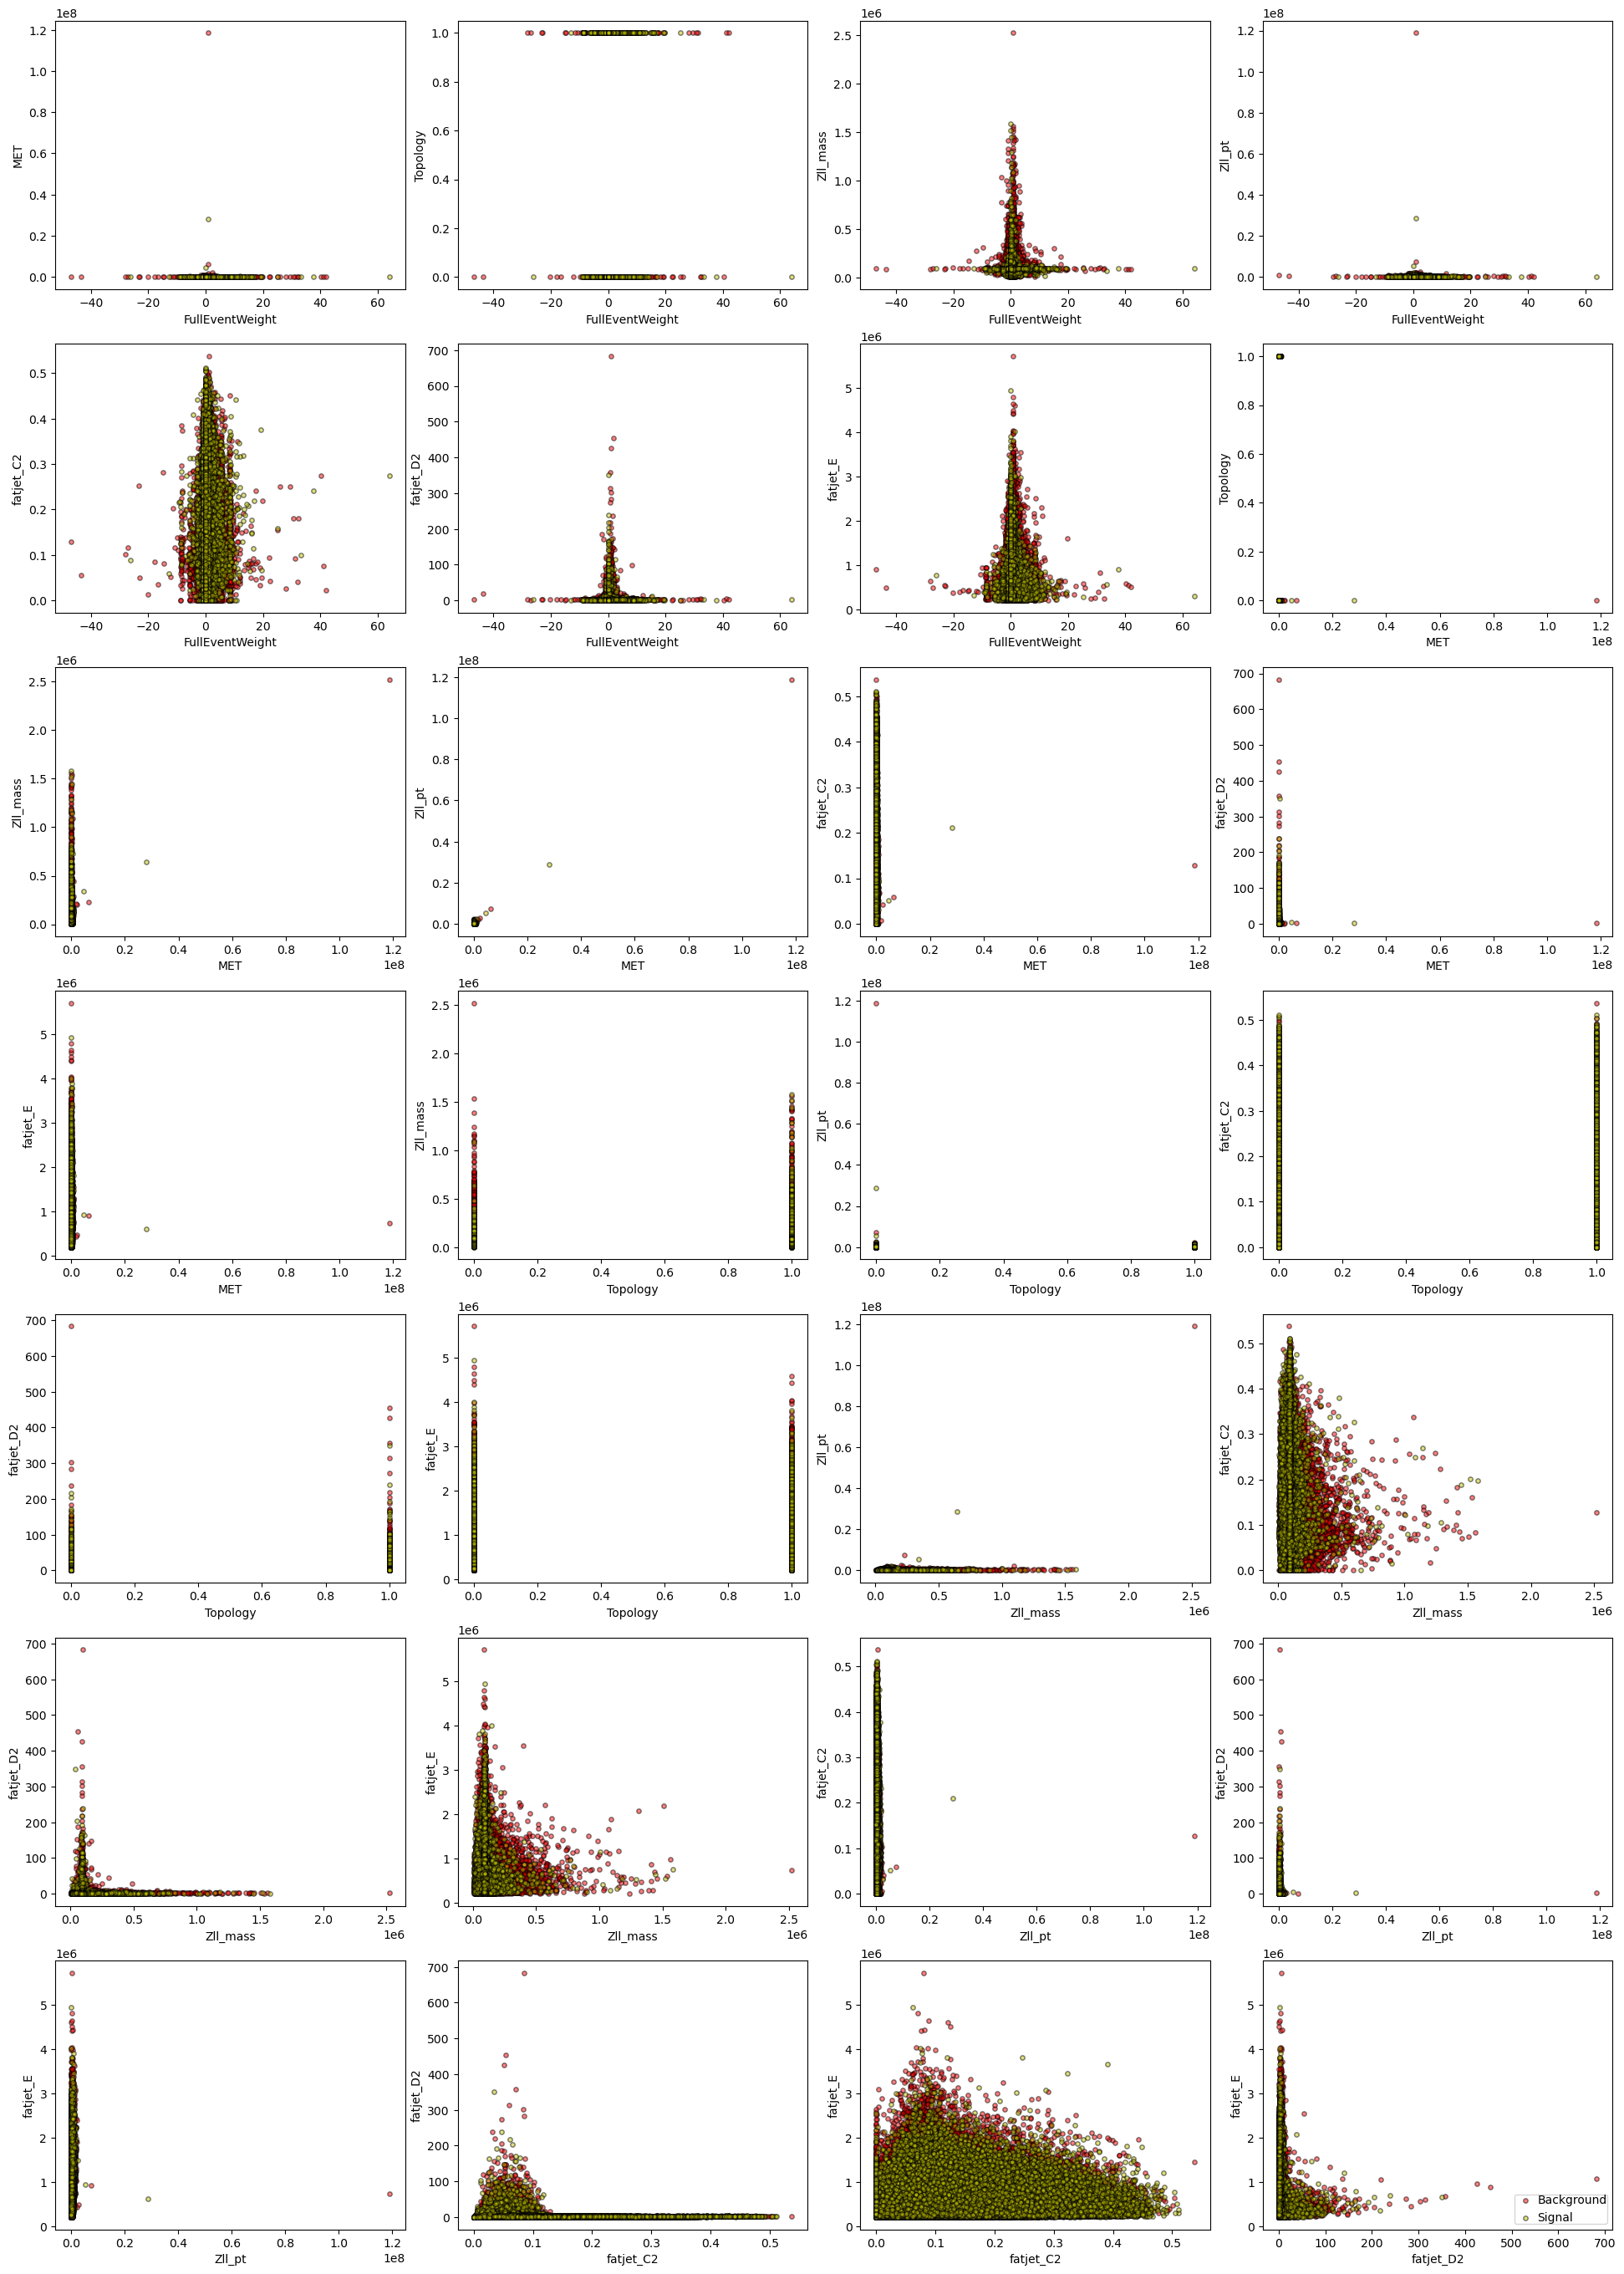

In [17]:
dt.featureplot(train_dataset.values, dataset['isSignal'].values, len(dataset['isSignal'].unique()), 
               t_names=train_dataset.keys().tolist(), c_names=['Background', 'Signal'])

#### Exercise #3 (1 point):
We start by performing input-feature scaling. We then split the dataset into training (70%) and test (30%) subsets:


In [18]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(train_dataset)
target = dataset['isSignal']

# set random seed
Answer_to_all_questions = 42

# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, test_size=0.3 , random_state=Answer_to_all_questions)

## SANITY CHECK ##
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(217177, 8) (217177,) (93077, 8) (93077,)


#### Exercise #4 (3 points):
(a) (2 points) Write a function that can create flexible NN models. 

Try running the NN with a batch size of 500, 50 epochs, 20 nodes per layer, and ```extra_depth = 1``` as a starting point. Put the result of the fit method call into a History object:
history = model.fit(train_data, train_target, batch_size=batchSize, epochs=N_epochs, verbose=1, validation_data=(test_data,test_target))

(b) (1 point) When the classification converges, use arrays ```History.history['loss']```
and ```History.history['val_accuracy']``` to plot the evolution of the loss-function (y-axis in log-scale) and the NN accuracy on the validation sample (y-axis in linear-scale) as a function of the epoch. You may use functions ```nn_utils.lossplot``` and ```nn_utils.accplot``` or write your own.

(a)

In [19]:
batchSize = 500
N_epochs = 50
num_nodes = 20

num_outputs = 1

In [20]:
def my_model(num_inputs, num_nodes, extra_depth):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))

    for i in range (extra_depth):
        # code up the extra layers here
        model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.1))
        
        # model.add(Dense(num_nodes/(2*i+1), kernel_initializer='normal', activation='relu'))
        # #model.add(Dropout(0.1))

    model.add(Dense(num_outputs, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [21]:
model = my_model(train_data.shape[1], num_nodes, 3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                180       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                4

In [22]:
history = model.fit(train_data, train_target, batch_size=batchSize, epochs=N_epochs, verbose=1, validation_data=(test_data, test_target))

Epoch 1/50
435/435 [==============================] - 4s 5ms/step - loss: 0.4670 - accuracy: 0.8045 - val_loss: 0.3558 - val_accuracy: 0.8484
Epoch 2/50
435/435 [==============================] - 2s 5ms/step - loss: 0.3610 - accuracy: 0.8478 - val_loss: 0.3473 - val_accuracy: 0.8527
Epoch 3/50
435/435 [==============================] - 3s 6ms/step - loss: 0.3553 - accuracy: 0.8505 - val_loss: 0.3445 - val_accuracy: 0.8544
Epoch 4/50
435/435 [==============================] - 2s 5ms/step - loss: 0.3525 - accuracy: 0.8514 - val_loss: 0.3434 - val_accuracy: 0.8534
Epoch 5/50
435/435 [==============================] - 2s 5ms/step - loss: 0.3502 - accuracy: 0.8521 - val_loss: 0.3404 - val_accuracy: 0.8562
Epoch 6/50
435/435 [==============================] - 2s 4ms/step - loss: 0.3480 - accuracy: 0.8532 - val_loss: 0.3378 - val_accuracy: 0.8555
Epoch 7/50
435/435 [==============================] - 2s 4ms/step - loss: 0.3462 - accuracy: 0.8537 - val_loss: 0.3362 - val_accuracy: 0.8576
Epoch 

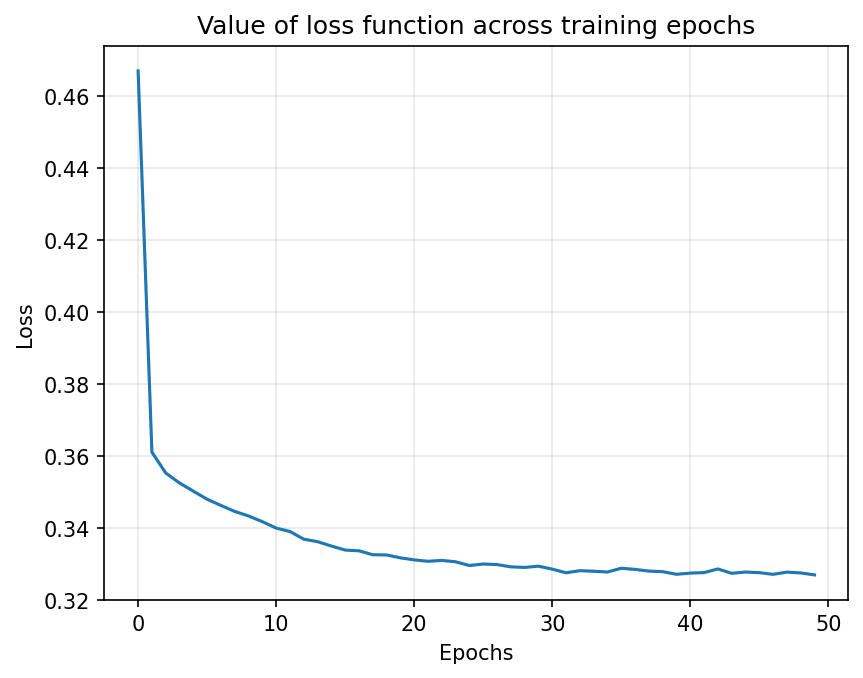

In [23]:
plt.figure(dpi=150)
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Value of loss function across training epochs')
plt.grid(alpha=0.3)
plt.show()

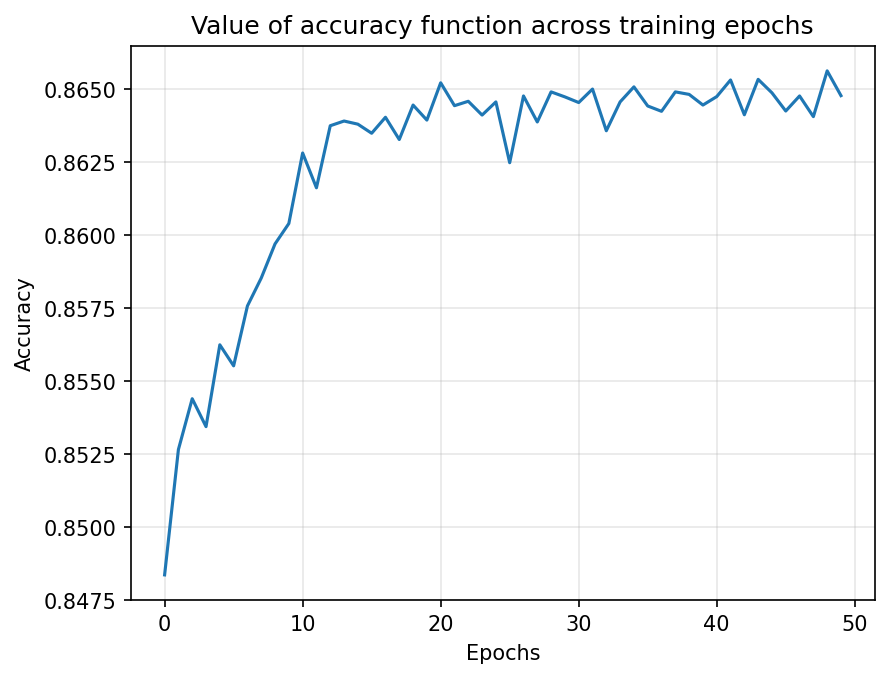

In [24]:
plt.figure(dpi=150)
plt.plot(history.history['val_accuracy'], label='Value Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Value of accuracy function across training epochs')
plt.grid(alpha=0.3)
plt.show()

#### Exercise #5 (2 points):
Having to find the best architecture by varying the numbers of layers and nodes, or the batch size and number of epochs is quite tedious. We will implement a callback hook that can automate the procedure for us, and exit the optimisation when the classification converges:

Try using this new method after you expand the set of input features to also include variable reco zv mass. Feel free to experiment with the architecture parameters. The goal is to achieve an accuracy (```val_accuracy```) of 95%. Plot the loss-function and ```NN_accuracy``` as a function of the epoch for the best classification method.


In [25]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(pd.concat([train_dataset, dataset['reco_zv_mass']], axis=1))
target = dataset['isSignal']

# set random seed
Answer_to_all_questions = 42

# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, test_size=0.3 , random_state=Answer_to_all_questions)
## SANITY CHECK ##
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(217177, 9) (217177,) (93077, 9) (93077,)


In [26]:
batchSize = 500
N_epochs = 100
num_nodes = 20

num_outputs = 1

In [27]:
def my_model(num_inputs, num_nodes, extra_depth):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))

    for i in range (extra_depth):   
        model.add(Dense(num_nodes, activation='relu'))
        num_nodes /= 2
        
    model.add(Dense(num_outputs, activation='sigmoid'))
    # Compile model
    #adam = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [28]:
model = my_model(train_data.shape[1], num_nodes, 3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                200       
                                                                 
 dense_6 (Dense)             (None, 20)                420       
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


In [29]:
# if we don’t have an increase of the accuracy for 10 epochs, terminate training.
# Always make sure that we ’re saving the model weights with the best accuracy.

callbacks_ = [EarlyStopping(verbose=True, patience=10, monitor='val_accuracy'), ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='max')]
history = model.fit(train_data, train_target, batch_size=batchSize, epochs=N_epochs, verbose=1, validation_data=(test_data, test_target), callbacks=callbacks_)

Epoch 1/100


435/435 [==============================] - 3s 4ms/step - loss: 0.4557 - accuracy: 0.8034 - val_loss: 0.3481 - val_accuracy: 0.8498
Epoch 2/100
435/435 [==============================] - 1s 3ms/step - loss: 0.3441 - accuracy: 0.8531 - val_loss: 0.3428 - val_accuracy: 0.8538
Epoch 3/100
435/435 [==============================] - 1s 3ms/step - loss: 0.3399 - accuracy: 0.8560 - val_loss: 0.3387 - val_accuracy: 0.8562
Epoch 4/100
435/435 [==============================] - 1s 3ms/step - loss: 0.3370 - accuracy: 0.8575 - val_loss: 0.3360 - val_accuracy: 0.8587
Epoch 5/100
435/435 [==============================] - 1s 3ms/step - loss: 0.3341 - accuracy: 0.8590 - val_loss: 0.3340 - val_accuracy: 0.8595
Epoch 6/100
435/435 [==============================] - 1s 3ms/step - loss: 0.3324 - accuracy: 0.8609 - val_loss: 0.3320 - val_accuracy: 0.8597
Epoch 7/100
435/435 [==============================] - 2s 3ms/step - loss: 0.3306 - accuracy: 0.8625 - val_loss: 0.3307 - val_accuracy: 0.8628
Epoch 8/100

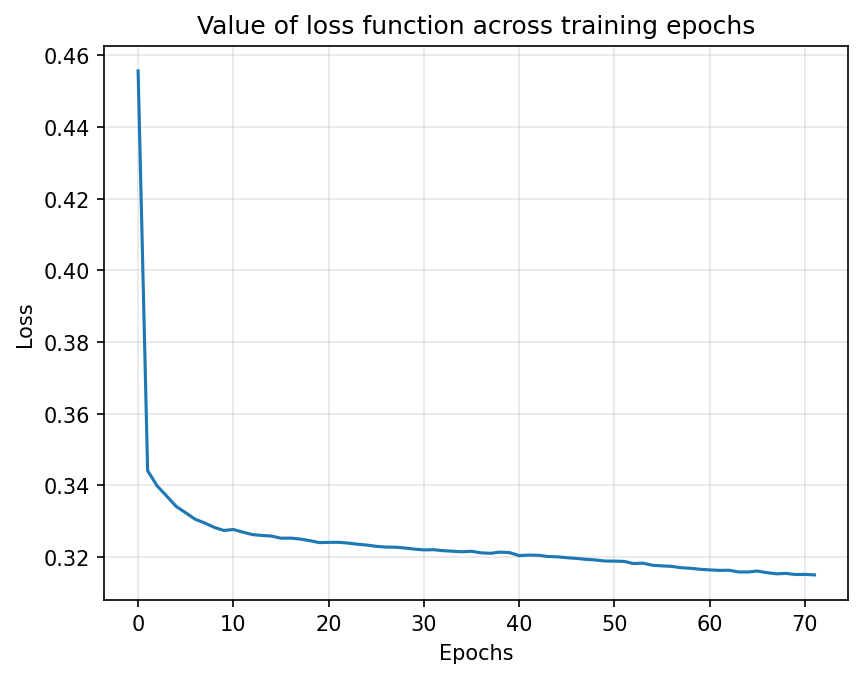

In [30]:
plt.figure(dpi=150)
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Value of loss function across training epochs')
plt.grid(alpha=0.3)
plt.show()

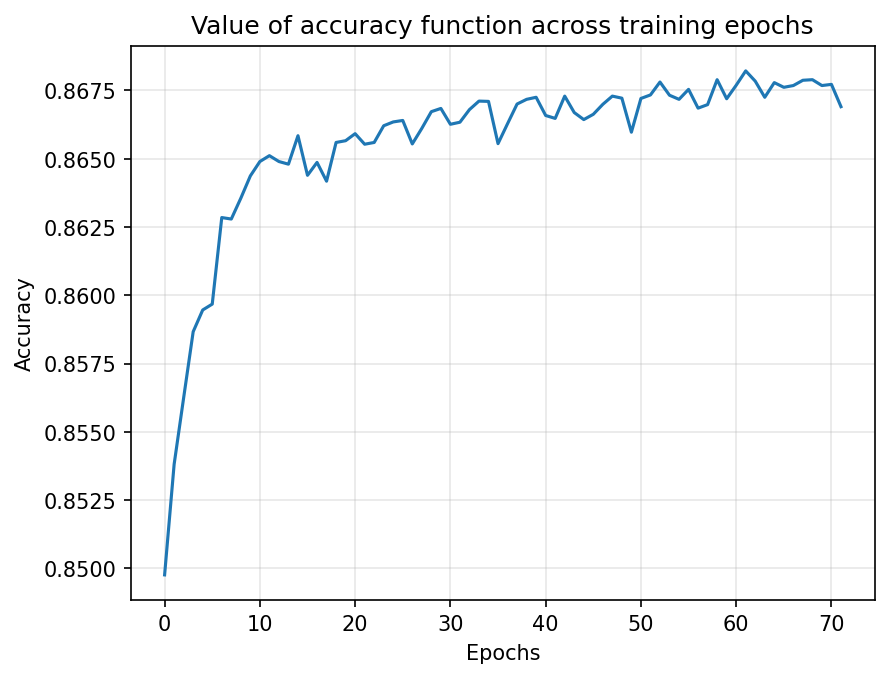

In [31]:
plt.figure(dpi=150)
plt.plot(history.history['val_accuracy'], label='Value Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Value of accuracy function across training epochs')
plt.grid(alpha=0.3)
plt.show()

#### Exercise #6 (1 point):
We will now try to visualise the results of the NN classifier. Use method ```keras.models.Model.predict``` to get the predicted categories for ```test data```. Notice that the output is not binary, but corresponds to a probability. Use a simple model (e.g. ```predicted = (predict_test_target>0.5)```) to turn the output into a binary decision. Use ```sklearn.metrics.confusion_matrix``` and ```nn_utils.heatmap``` to plot the “confusion matrix” on a 2 × 2 grid.

A more advanced way of showing the NN classifier performance is by producing a ROC curve. Use ```sklearn.metrics.roc_curve``` to get the False Positive Rate (i.e. effectively: background efficiency) and True Positive Rate (i.e. effectively: signal efficiency). Plot the ROC curve. What would you say the optimal performance point is?

In [32]:
model.load_weights('model.h5')

In [33]:
# predict the categories
predict_test_target = model.predict(test_data)
predicted = (predict_test_target > 0.5)

2909/2909 [==============================] - 4s 1ms/step


In [34]:
def heatmap(arr):
    plt.figure(dpi=100)
    arr = (arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]).round(2)
    plt.imshow(arr, cmap=sns.light_palette('Green', as_cmap=True))

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    cbar = plt.colorbar()
    cbar.outline.set_visible(False)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for i in range(2):
        for j in range(2):
            # white text if the background is dark, black text if the background is light
            plt.text(j, i, arr[i, j], ha='center', va='center', color='black')

    plt.show()

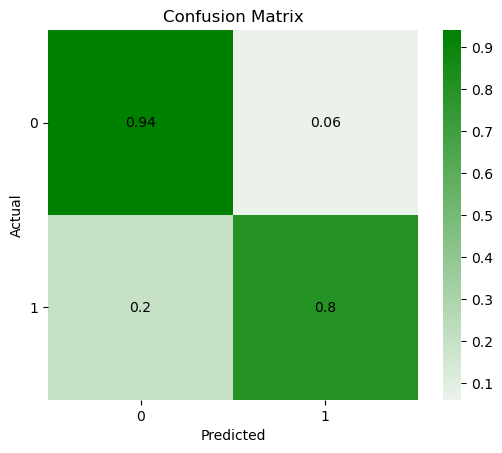

In [35]:
sklearn_cm = confusion_matrix(test_target, predicted)
heatmap(sklearn_cm)

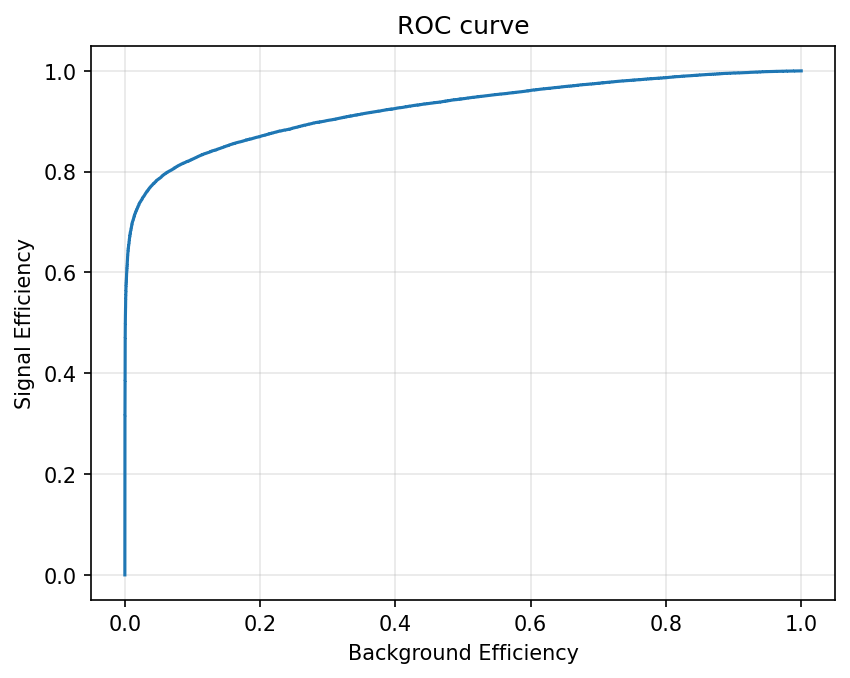

In [36]:
roc_c = roc_curve(test_target, predict_test_target)

plt.figure(dpi=150)
plt.plot(roc_c[0], roc_c[1])
plt.xlabel('Background Efficiency') # False Positive Rate
plt.ylabel('Signal Efficiency') # True Positive Rate
plt.title('ROC curve')
plt.grid(alpha=0.3)
plt.show()

The point closest to the (0, 1) coordinate is the taken to be the most optimal performance point on an ROC curve. The idea is would like to accept where we have no false posivites and with all true positives. In this case, the point that shows the least Background effiency and high signal effiency can be taken as the optimal value. This value is show to be (0.77, 0.02), meaning at 77% Signal efficiency.